In [1]:
import numpy as np
from k_local import build_local
import itertools

Q = np.array([
        [2,1],
        [1,2]
    ])

## Criação da discretização 2D, numeração dos nós e numeração dos elementos

In [2]:
nx = 5
ny = 5
X, Y = np.meshgrid(np.linspace(0,1,nx), np.linspace(0,1,ny))

In [3]:
print(X.shape, Y.shape)

(5, 5) (5, 5)


In [4]:
Z = np.array(list(zip(X.ravel(), Y.ravel())))
print(Z.shape)

(25, 2)


In [5]:
nodes = list(enumerate(Z))
nodes_n = nodes[-1][0] + 1
print(nodes_n)

25


In [6]:
elements_n = (nx-1)*(ny-1)
print(elements_n)

16


In [7]:
G = np.zeros((4,elements_n), dtype=np.int64)

In [8]:
num = 0

for d in range(ny-1):
    for i in range((nx-1)):
        G[:,num] = np.array([i+d*nx, i+1+d*nx, i+nx+1+d*nx, i+nx+d*nx])
        num+=1
        
for x in range(G.shape[1]):
    print(G[:,x])

[0 1 6 5]
[1 2 7 6]
[2 3 8 7]
[3 4 9 8]
[ 5  6 11 10]
[ 6  7 12 11]
[ 7  8 13 12]
[ 8  9 14 13]
[10 11 16 15]
[11 12 17 16]
[12 13 18 17]
[13 14 19 18]
[15 16 21 20]
[16 17 22 21]
[17 18 23 22]
[18 19 24 23]


## Montagem da matriz rigidez local, e posterior mapeamento para a matriz rigidez global

In [9]:
def map_nodes_to_physical(G, elem, verbose=False):
    n_ = G[:,elem]
    l = list()
    
    for idx in n_:
        l.append(nodes[int(idx)][1])
        if verbose:
            print('global node {0} --> point {1} on R2'.format(idx, nodes[int(idx)][1]))
        
    M = np.array(l).T
    return M

In [10]:
def l2g(EQ_vector, L2G_matrix, Q_ab, f, prescribed, verbose=False):
    #L2G_matrix sera o n_
    nodes_per_elem, elem_n = L2G_matrix.shape
    
    if verbose:
        print(nodes_per_elem, elem_n)
    
    eq_n = int(np.max(EQ_vector) + 1)
    
    if verbose:
        print(eq_n)
    
    K = np.zeros((eq_n, eq_n))
    F = np.zeros((eq_n, ))
    
    for elem in range(elem_n):
        global_nodes = L2G_matrix[:,elem]
        f_on_nodes = f[global_nodes]
        pres_on_nodes = prescribed[global_nodes]
        
        if verbose:
            print('global nodes --> {0}'.format(global_nodes))
            print('f on nodes --> {0}'.format(f_on_nodes))
            print('prescribed on nodes --> {0}'.format(pres_on_nodes))
            
        c = itertools.product(range(nodes_per_elem),repeat=2)
        M = map_nodes_to_physical(L2G_matrix, elem, verbose=verbose)
        local_k, local_F = build_local(M, Q, Q_ab, f_on_nodes, pres_on_nodes)
        
        for x in c:
            aux1 = L2G_matrix[x[0]][elem]
            aux2 = L2G_matrix[x[1]][elem]    
            i = EQ_vector[aux1]
            j = EQ_vector[aux2]
            
            if verbose:
                print('el_node {0} --> glob_node {1} --> eq_vec {2}'.format((x), (aux1, aux2), (i, j)))
                
            if i != -1 and j != -1:
                K[i][j] += local_k[x[0]][x[1]]
                
                if verbose:
                    print('\t----> accumulating to global')
        
        for node in global_nodes:
            i = EQ_vector[node]
            print('node {0} --> equation {1}'.format(node, i))
            if i != -1:
                print('\tnode {0} --> pos {1} on local_f'.format(node, np.where(global_nodes == node)[0]))
                F[i] += local_F[np.where(global_nodes == node)[0]]
        
        if verbose:
            print('+'*60)

    return K, F

In [11]:
EQ_vector = np.zeros((nodes_n,), dtype=np.int64) - 1
count = 0

for idx in range(EQ_vector.shape[0]):
    if idx in [6,7,8,11,12,13,16,17,18]:
        EQ_vector[idx] = count
        count += 1

In [12]:
print(EQ_vector)

[-1 -1 -1 -1 -1 -1  0  1  2 -1 -1  3  4  5 -1 -1  6  7  8 -1 -1 -1 -1 -1 -1]


In [13]:
phi_1 = lambda ksi, eta: 0.25*(1-ksi)*(1-eta)
phi_2 = lambda ksi, eta: 0.25*(1+ksi)*(1-eta)
phi_3 = lambda ksi, eta: 0.25*(1+ksi)*(1+eta)
phi_4 = lambda ksi, eta: 0.25*(1-ksi)*(1+eta)

gauss_points = [[-np.sqrt(3)/3,-np.sqrt(3)/3],
                [np.sqrt(3)/3, -np.sqrt(3)/3],
                [np.sqrt(3)/3, np.sqrt(3)/3],
                [-np.sqrt(3)/3, np.sqrt(3)/3]]

interp = np.array([phi_1, phi_2, phi_3, phi_4])

Q_ab = np.zeros((4,4))

verbose = True
for i in range(4):
    for j in range(4):
        for pg in gauss_points:
            Q_ab[i, j] += interp[i](pg[0], pg[1])*interp[j](pg[0], pg[1])
            
            if verbose:
                print('({0}, {1}) --> pg = ({2}, {3})'.format(i, j, pg[0], pg[1]))
        
        if verbose:
            print('+'*60)

(0, 0) --> pg = (-0.5773502691896257, -0.5773502691896257)
(0, 0) --> pg = (0.5773502691896257, -0.5773502691896257)
(0, 0) --> pg = (0.5773502691896257, 0.5773502691896257)
(0, 0) --> pg = (-0.5773502691896257, 0.5773502691896257)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(0, 1) --> pg = (-0.5773502691896257, -0.5773502691896257)
(0, 1) --> pg = (0.5773502691896257, -0.5773502691896257)
(0, 1) --> pg = (0.5773502691896257, 0.5773502691896257)
(0, 1) --> pg = (-0.5773502691896257, 0.5773502691896257)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(0, 2) --> pg = (-0.5773502691896257, -0.5773502691896257)
(0, 2) --> pg = (0.5773502691896257, -0.5773502691896257)
(0, 2) --> pg = (0.5773502691896257, 0.5773502691896257)
(0, 2) --> pg = (-0.5773502691896257, 0.5773502691896257)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(0, 3) --> pg = (-0.5773502691896257, -0.5773502691896257)
(0, 3) --> pg = (0.5773502691896257, -0.5773502691896257)
(0, 

In [14]:
f_ = lambda x: (2*np.pi**2)*(2*np.sin(np.pi*x[0])*np.cos(np.pi*x[1]) + np.cos(np.pi*x[0])*np.sin(np.pi*x[1]))
f = np.zeros((nodes_n,))
for pts in nodes:
    f[pts[0]] = f_(pts[1])

In [15]:
print(f)

[  0.00000000e+00   2.79154568e+01   3.94784176e+01   2.79154568e+01
   4.83471178e-15   1.39577284e+01   2.96088132e+01   2.79154568e+01
   9.86960440e+00  -1.39577284e+01   1.97392088e+01   1.39577284e+01
   3.62603383e-15  -1.39577284e+01  -1.97392088e+01   1.39577284e+01
  -9.86960440e+00  -2.79154568e+01  -2.96088132e+01  -1.39577284e+01
   2.41735589e-15  -2.79154568e+01  -3.94784176e+01  -2.79154568e+01
  -7.25206766e-15]


In [16]:
prescribed = np.zeros((nodes_n, ))

gamma_1 = np.where(Z[:,1] == 0)[0]
print('gamma_1 {0}'.format(gamma_1))
prescribed[gamma_1] = np.sin(np.pi*Z[gamma_1,0])

gamma_2 = np.where(Z[:,0] == 1)[0]
print('gamma_2 {0}'.format(gamma_2))

gamma_3 = np.where(Z[:,1] == 1)[0]
print('gamma_3 {0}'.format(gamma_3))
prescribed[gamma_3] = -np.sin(np.pi*Z[gamma_3,0])
gamma_4 = np.where(Z[:,0] == 0)[0]
print('gamma_4 {0}'.format(gamma_4))

print('prescribed {0}'.format(prescribed))

gamma_1 [0 1 2 3 4]
gamma_2 [ 4  9 14 19 24]
gamma_3 [20 21 22 23 24]
gamma_4 [ 0  5 10 15 20]
prescribed [  0.00000000e+00   7.07106781e-01   1.00000000e+00   7.07106781e-01
   1.22464680e-16   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -7.07106781e-01  -1.00000000e+00  -7.07106781e-01
  -1.22464680e-16]


In [17]:
K, F = l2g(EQ_vector, G, Q_ab, f, prescribed, verbose=True)

4 16
9
global nodes --> [0 1 6 5]
f on nodes --> [  0.         27.9154568  29.6088132  13.9577284]
prescribed on nodes --> [ 0.          0.70710678  0.          0.        ]
global node 0 --> point [ 0.  0.] on R2
global node 1 --> point [ 0.25  0.  ] on R2
global node 6 --> point [ 0.25  0.25] on R2
global node 5 --> point [ 0.    0.25] on R2
el_node (0, 0) --> glob_node (0, 0) --> eq_vec (-1, -1)
el_node (0, 1) --> glob_node (0, 1) --> eq_vec (-1, -1)
el_node (0, 2) --> glob_node (0, 6) --> eq_vec (-1, 0)
el_node (0, 3) --> glob_node (0, 5) --> eq_vec (-1, -1)
el_node (1, 0) --> glob_node (1, 0) --> eq_vec (-1, -1)
el_node (1, 1) --> glob_node (1, 1) --> eq_vec (-1, -1)
el_node (1, 2) --> glob_node (1, 6) --> eq_vec (-1, 0)
el_node (1, 3) --> glob_node (1, 5) --> eq_vec (-1, -1)
el_node (2, 0) --> glob_node (6, 0) --> eq_vec (0, -1)
el_node (2, 1) --> glob_node (6, 1) --> eq_vec (0, -1)
el_node (2, 2) --> glob_node (6, 6) --> eq_vec (0, 0)
	----> accumulating to global
el_node (2, 3) 

	node 17 --> pos [2] on local_f
node 16 --> equation 6
	node 16 --> pos [3] on local_f
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
global nodes --> [12 13 18 17]
f on nodes --> [  3.62603383e-15  -1.39577284e+01  -2.96088132e+01  -2.79154568e+01]
prescribed on nodes --> [ 0.  0.  0.  0.]
global node 12 --> point [ 0.5  0.5] on R2
global node 13 --> point [ 0.75  0.5 ] on R2
global node 18 --> point [ 0.75  0.75] on R2
global node 17 --> point [ 0.5   0.75] on R2
el_node (0, 0) --> glob_node (12, 12) --> eq_vec (4, 4)
	----> accumulating to global
el_node (0, 1) --> glob_node (12, 13) --> eq_vec (4, 5)
	----> accumulating to global
el_node (0, 2) --> glob_node (12, 18) --> eq_vec (4, 8)
	----> accumulating to global
el_node (0, 3) --> glob_node (12, 17) --> eq_vec (4, 7)
	----> accumulating to global
el_node (1, 0) --> glob_node (13, 12) --> eq_vec (5, 4)
	----> accumulating to global
el_node (1, 1) --> glob_node (13, 13) --> eq_vec (5, 5)
	----> accumulating to global


In [18]:
K == K.T

array([[ True,  True,  True, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True, False,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True, False,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]], dtype=bool)

In [19]:
print('{0} == {1}'.format(K[3,0], K[0,3]))
print('{0} == {1}'.format(K[4,1], K[1,4]))
print('{0} == {1}'.format(K[5,2], K[2,5]))

-0.666666666666667 == -0.6666666666666667
-0.6666666666666664 == -0.6666666666666663
-0.6666666666666664 == -0.6666666666666663


In [20]:
for x in F:
    print(x)

2.1449186167
3.03014508882
2.14035366387
0.710334690285
4.16333634234e-16
-0.710334690285
-2.14035366387
-3.03014508882
-2.1449186167


In [21]:
d = np.linalg.solve(K, F)

In [22]:
for x in d:
    print(x)

0.488862296711
0.68934808206
0.486963276411
0.00417236657972
2.85551245605e-16
-0.00417236657972
-0.486963276411
-0.68934808206
-0.488862296711


In [23]:
known_sols = np.concatenate((gamma_1, gamma_2, gamma_3, gamma_4),axis=0)

In [24]:
known_sols

array([ 0,  1,  2,  3,  4,  4,  9, 14, 19, 24, 20, 21, 22, 23, 24,  0,  5,
       10, 15, 20])

In [25]:
d_sols = np.setdiff1d(np.arange(nodes_n), known_sols)

In [26]:
d_sols

array([ 6,  7,  8, 11, 12, 13, 16, 17, 18])

In [27]:
sols = prescribed
sols[d_sols] = d

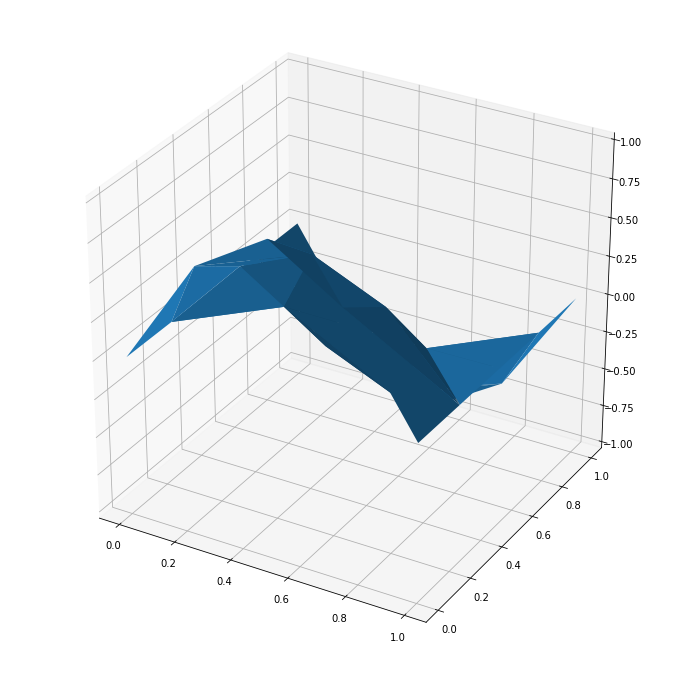

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

X, Y = Z[:,0], Z[:,1]

ax.plot_trisurf(X, Y, sols)
plt.show()